In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Load and preprocess the data

In [ ]:
df = pd.read_csv("RELIANCE.csv")

In [ ]:
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,RELIANCE,EQ,1904.35,1920.00,1962.00,1911.50,1938.00,1937.85,1941.32,9620785,1.867699e+15,259137.0,4276703.0,0.4445
5302,2021-04-27,RELIANCE,EQ,1937.85,1940.00,1997.20,1938.25,1990.00,1988.65,1978.64,9226547,1.825602e+15,291197.0,3772144.0,0.4088
5303,2021-04-28,RELIANCE,EQ,1988.65,1997.85,2008.00,1980.15,1993.15,1997.30,1997.60,7902002,1.578508e+15,247331.0,3921560.0,0.4963
5304,2021-04-29,RELIANCE,EQ,1997.30,2022.90,2044.50,2007.30,2020.00,2024.05,2024.21,8035915,1.626634e+15,213153.0,2834103.0,0.3527


Display the first five rows

In [ ]:
df.head(5)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


 Display basic information about the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              5306 non-null   object 
 1   Series              5306 non-null   object 
 2   Prev Close          5306 non-null   float64
 3   Open                5306 non-null   float64
 4   High                5306 non-null   float64
 5   Low                 5306 non-null   float64
 6   Last                5306 non-null   float64
 7   Close               5306 non-null   float64
 8   VWAP                5306 non-null   float64
 9   Volume              5306 non-null   int64  
 10  Turnover            5306 non-null   float64
 11  Trades              2456 non-null   float64
 12  Deliverable Volume  4792 non-null   float64
 13  %Deliverble         4792 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 750.8+ KB


Check for missing values

In [ ]:
df.isnull().sum()

,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0
Volume,0


Convert 'Date' to datetime and sort the dataset by date

In [ ]:
df['Date'] = pd.to_datetime(df.index)
df = df.sort_index()

Set 'Date' as index

In [ ]:
df.set_index('Date', inplace=True)

Select the 'Close' column as the main target variable

In [ ]:
close_prices = df['Close'].asfreq('B')

Handle missing values by forward filling

In [ ]:
close_prices = close_prices.ffill()

Visualize the closing prices


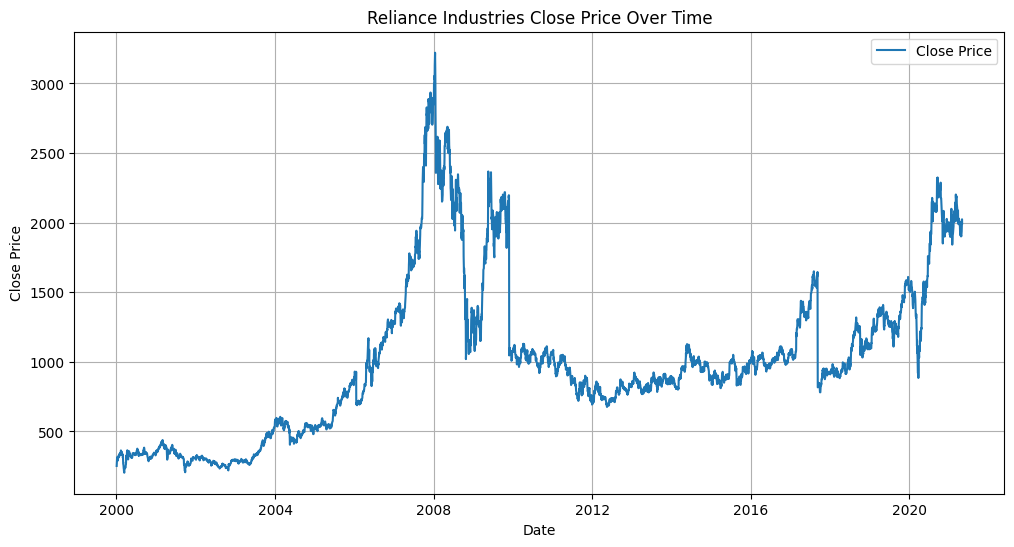

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Close Price')
plt.title("Reliance Industries Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Train-test split

In [ ]:
train = close_prices[:-365]
test = close_prices[-365:]

#1. ARIMA

In [ ]:
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print("RMSE ARIMA:", rmse_arima)


RMSE ARIMA: 412.9593497021491


# 2. SARIMA

In [ ]:
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.forecast(steps=len(test))
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
print("RMSE SARIMA:", rmse_sarima)


RMSE SARIMA: 373.52979763658857


# 3. SARIMAX (using Volume as exogenous variable)

In [ ]:
exog = df['Volume'].asfreq('B').ffill()
exog_train = exog[:-365]
exog_test = exog[-365:]
model_sarimax = SARIMAX(train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarimax_fit = model_sarimax.fit(disp=False)
forecast_sarimax = model_sarimax_fit.forecast(steps=len(test), exog=exog_test)
rmse_sarimax = np.sqrt(mean_squared_error(test, forecast_sarimax))
print("RMSE SARIMAX:", rmse_sarimax)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE SARIMAX: 537.4970212879316


# 4. Facebook Prophet

In [ ]:
df_prophet = close_prices.reset_index()
df_prophet.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(df_prophet[:-365])
future = model_prophet.make_future_dataframe(periods=365)
forecast_prophet = model_prophet.predict(future)
prophet_forecast = forecast_prophet['yhat'][-365:].values
rmse_prophet = np.sqrt(mean_squared_error(test, prophet_forecast))
print("RMSE Prophet:", rmse_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4a98b4y/d1qzksbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4a98b4y/wjhwq65h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82492', 'data', 'file=/tmp/tmpn4a98b4y/d1qzksbb.json', 'init=/tmp/tmpn4a98b4y/wjhwq65h.json', 'output', 'file=/tmp/tmpn4a98b4y/prophet_model66t1f6c7/prophet_model-20250531181359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE Prophet: 587.1869591643165


# 5. LSTM

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))
train_scaled = scaled_data[:-365]
test_scaled = scaled_data[-365:]

X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

inputs = scaled_data[len(scaled_data)-len(test_scaled)-60:]
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
rmse_lstm = np.sqrt(mean_squared_error(test, predicted_stock_price))
print("RMSE LSTM:", rmse_lstm)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
RMSE LSTM: 77.51583492218981


# Model comparison summary

In [ ]:
model_rmse = {
    "ARIMA": rmse_arima,
    "SARIMA": rmse_sarima,
    "SARIMAX": rmse_sarimax,
    "Prophet": rmse_prophet,
    "LSTM": rmse_lstm
}

# Sort by lowest RMSE
sorted_models = sorted(model_rmse.items(), key=lambda x: x[1])
print("\n--- Model RMSE Comparison ---")
for model, rmse in sorted_models:
    print(f"{model}: RMSE = {rmse:.4f}")

# Best model
best_model = sorted_models[0]
print(f"\n Best Model: {best_model[0]} with RMSE = {best_model[1]:.4f}")



--- Model RMSE Comparison ---
LSTM: RMSE = 77.5158
SARIMA: RMSE = 373.5298
ARIMA: RMSE = 412.9593
SARIMAX: RMSE = 537.4970
Prophet: RMSE = 587.1870

 Best Model: LSTM with RMSE = 77.5158
